<a href="https://colab.research.google.com/github/OsyaginVictor/Forecasting-taxi-orders/blob/main/Forecasting_taxi_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Первым делом загрузим нужные нам библиотеки

In [ ]:
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import torch
from torch import nn

Далее выгрузим таблицу, проведем предобработку, ресемплирование и анализ.

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
print('Данные')
display(df.head(8))
print('\n')
print('Размер датасета:', df.shape)
print('\n')
print('Информация\n')
print(df.info())
print('\n')
print('Описание\n')
print(df.describe())

Данные


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5




Размер датасета: (26496, 1)


Информация

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Описание

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


Произведем рессемплирование

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

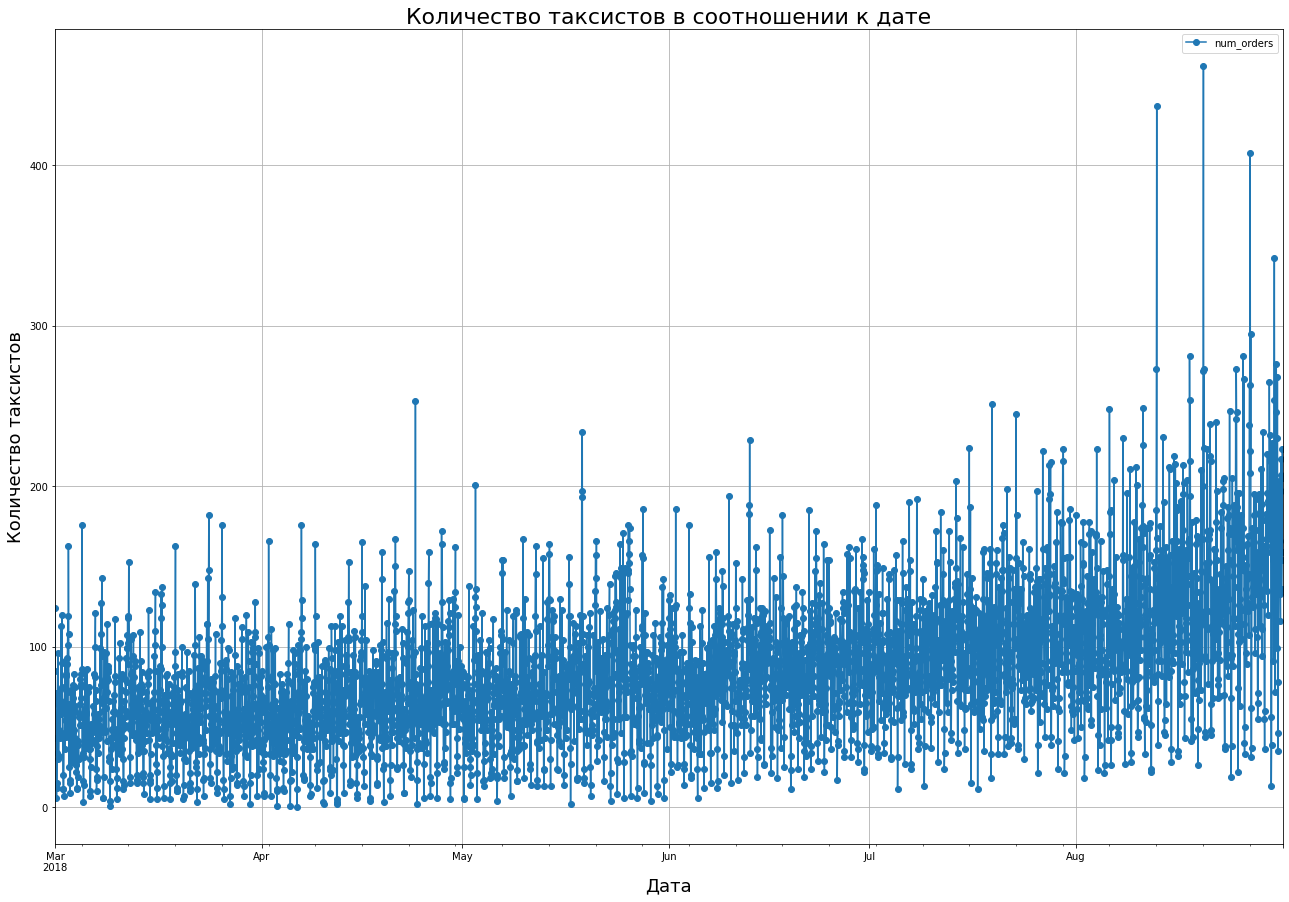

In [ ]:
# Сброс индекса и преобразование в столбец
df_reset = df.reset_index()

# Построение графика
df_reset.plot(x='datetime', y='num_orders', figsize=(22, 15), marker='o')

# Настройка заголовка и меток осей
plt.title('Количество таксистов в соотношении к дате', fontsize=22)
plt.xlabel('Дата',fontsize=18)
plt.ylabel('Количество таксистов',fontsize=18)
plt.grid(True) # Добавляем сетку
# Отображение графика
plt.show()

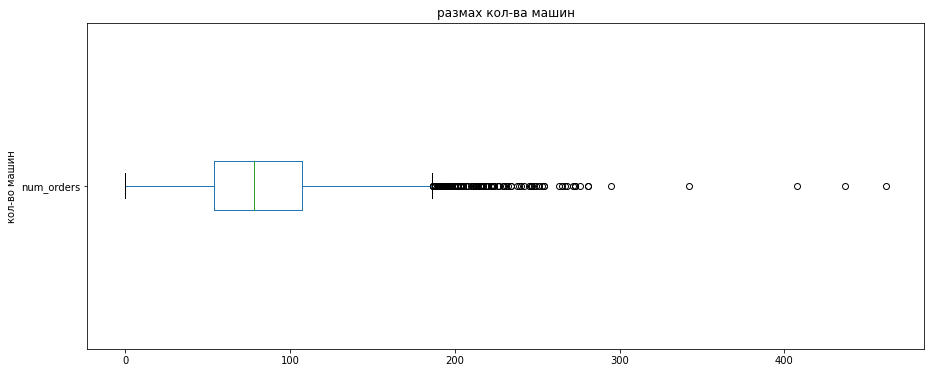

In [ ]:
df['num_orders'].plot(kind = 'box', title = 'размах кол-ва машин', ylabel = 'кол-во машин',figsize=(15, 6), vert=False);

Колебания величины имеют высокий уровень нестабильности - их значения могут различаться от почти нуля до приблизительно 450 в час. Тем не менее, мы наблюдаем положительную тенденцию и последовательное увеличение числа заказов с весны до осени 2018 года. Удалим данные, где значения больше 300.

In [ ]:
df = df[df['num_orders'] < 300]

In [ ]:
# Функция для создания дополнительных признаков
def add_features(data, lag, rolling):
    # Календарные признаки
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    # Отстающие значения
    for lag in range(1, lag):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    # Скользящее среднее по определенному количеству значений
    df[f'rolling_mean_{rolling}'] = df['num_orders'].shift().rolling(rolling).mean()

    return df

# Создание дополнительных признаков для существующего датафрейма
df = add_features(df, lag=18, rolling=18)
display(df.head())

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,rolling_mean_18
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


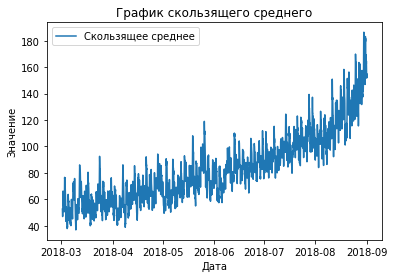

In [ ]:
# График скользящего среднего
plt.plot(df.index, df['rolling_mean_18'], label='Скользящее среднее')

# Дополнительные настройки графика

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('График скользящего среднего')
plt.legend()

# Вывод графика на экран
plt.show()

На втором графике отчетливо видно, что количество заказов в течение одних суток стабильно росло с марта 2018 года (приблизительно 50 заказов) до сентября 2018 года (более 160 заказов).

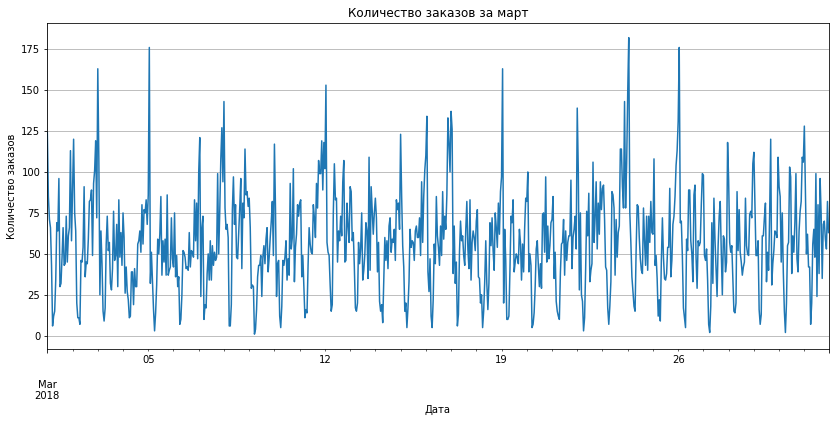

In [ ]:
df_taxi_march = df['2018.03.01':'2018.03.31']
plt.figure(figsize=(14, 6))
df_taxi_march['num_orders'].plot(title="Количество заказов за март", xlabel="Дата", ylabel="Количество заказов")
plt.grid(True)
plt.show()

В рассматриваемом периоде временной ряд характеризуется стабильностью, но при этом наблюдаются значительные колебания от небольших значений до более чем 175. Следующим шагом рассмотрим тренд и сезонность на представленных данных.

Для анализа сезонности мы рассмотрим недельный интервал с 5 по 11 марта.

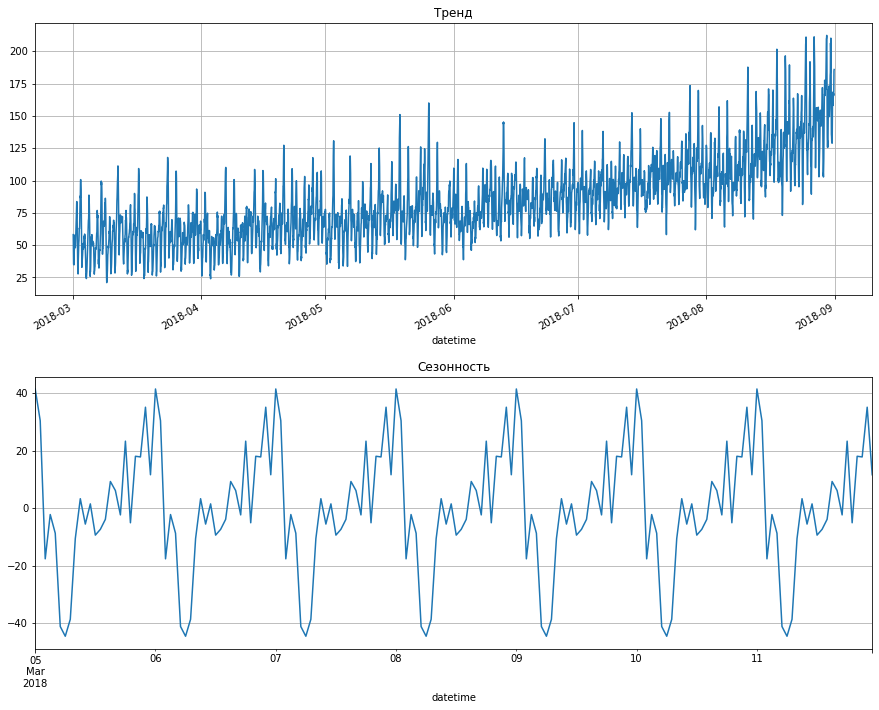

In [ ]:
decomposed = seasonal_decompose(df['num_orders'], period=7)

plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.trend.plot(title='Тренд', ax=plt.gca())
plt.grid(True)


week_df = df['2018.03.05':'2018.03.11']

decomposed_week = seasonal_decompose(week_df['num_orders'])

plt.subplot(312)
decomposed_week.seasonal.plot(title='Сезонность', ax=plt.gca())
plt.grid()

plt.subplots_adjust(hspace=0.3)  # Увеличение вертикального отступа между графиками

plt.show()

Анализ данных показывает, что на протяжении всего периода с марта по сентябрь 2018 года наблюдался устойчивый восходящий тренд. Количество заказов выросло с примерно 50 в марте до около 170 в сентябре 2018 года, что представляет собой более чем трёхкратное увеличение за данный период.

При анализе сезонности на недельном интервале стало ясно, что общее количество заказов сильно зависит от времени суток. Однако стоит отметить, что в данном случае цикличность, выражающая сезонность, равна одному дню, что подтверждает повторяющийся паттерн каждые сутки.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4412 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4412 non-null   int64  
 1   month            4412 non-null   int64  
 2   day              4412 non-null   int64  
 3   dayofweek        4412 non-null   int64  
 4   lag_1            4411 non-null   float64
 5   lag_2            4410 non-null   float64
 6   lag_3            4409 non-null   float64
 7   lag_4            4408 non-null   float64
 8   lag_5            4407 non-null   float64
 9   lag_6            4406 non-null   float64
 10  lag_7            4405 non-null   float64
 11  lag_8            4404 non-null   float64
 12  lag_9            4403 non-null   float64
 13  lag_10           4402 non-null   float64
 14  lag_11           4401 non-null   float64
 15  lag_12           4400 non-null   float64
 16  lag_13           4399 no

## Обучение

Данные будут поделены на обучающий и тестовый наборы. Затем мы устраним отсутствующие значения и перейдем к обучению моделей машинного обучения.

Планирую применить линейную регрессию, случайный лес, дерево решений и нейронную сеть для обучения. Наша цель - добиться значения среднеквадратичной ошибки на тестовой выборке не более 48.

In [ ]:
# Разделение данных на тренировочную и тестовую выборки
train, test = train_test_split(
    df,
    shuffle=False,
    test_size=0.1
)

# Удаление пропущенных значений
train = train.dropna()

# Тренировочная выборка
x_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

# Тестовая выборка
x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# Масштабирование
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Линейная регрессия

In [ ]:
linear = LinearRegression()

linear.fit(x_train, y_train)
linear_pred_train = linear.predict(x_train)

linear_train_rmse = np.sqrt(mean_squared_error(y_train, linear_pred_train))
print('\tRMSE:', round(linear_train_rmse, 2))

	RMSE: 29.04


### Деревья

Напишем функцию best_parameters, которая будет использоваться для нахождения лучших гиперпараметров модели с помощью кросс-валидации и GridSearchCV (поиск по сетке). Функция принимает модель в качестве аргумента, затем она выполняет перебор гиперпараметров для этой модели с использованием временного ряда разделения (TimeSeriesSplit).

In [ ]:
# Получение RMSE у лучшей модели
def best_parameters(model):
    ts = TimeSeriesSplit()

    # Перебор гиперпараметров
    grid = GridSearchCV(model, param_grid, cv=ts, scoring='neg_root_mean_squared_error')
    grid.fit(x_train, y_train)

    print(grid.best_estimator_)

    # Поскольку GridSearchCV работает на максимизацию метрики, то использовается инвентированное значение RMSE
    print('RMSE:', round(grid.best_score_ * -1, 3))

#### Деревья решений

In [ ]:
tree = DecisionTreeRegressor(random_state=42)

# Гиперпараметры для перебора
param_grid = {
    'max_depth': range(5, 31, 3),
    'max_features': [None, 'log2', 'sqrt'],
    'max_leaf_nodes': range(2, 21,8)
}

best_parameters(tree)

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=18, random_state=42)
RMSE: 32.766


#### Случайный лес

In [ ]:
%%time

forest = RandomForestRegressor(random_state=42)

# Гиперпараметры для перебора
param_grid = {
    'max_depth': range(5, 31, 3),
    'max_leaf_nodes': range(2, 21,8)
}

best_parameters(forest)

RandomForestRegressor(max_depth=8, max_leaf_nodes=18, random_state=42)
RMSE: 30.094
CPU times: user 1min 36s, sys: 318 ms, total: 1min 37s
Wall time: 1min 37s


#### Нейросеть

In [ ]:
# Установка random seed
torch.manual_seed(42)
np.random.seed(42)

x_train_torch = torch.FloatTensor(x_train)
x_test_torch = torch.FloatTensor(x_test)
y_train_torch = torch.FloatTensor(y_train.values)
y_test_torch = torch.FloatTensor(y_test.values)

# Число нейронов в каждом слое
in_neurons = x_train.shape[1]
hidden_neurons_1 = 16
hidden_neurons_2 = 8
out_neurons = 1

# Нейронная сеть
net = nn.Sequential(
    nn.Linear(in_neurons, hidden_neurons_1),
    nn.BatchNorm1d(hidden_neurons_1),
    nn.LeakyReLU(),
    nn.Linear(hidden_neurons_1, hidden_neurons_2),
    nn.BatchNorm1d(hidden_neurons_2),
    nn.LeakyReLU(),
    nn.Linear(hidden_neurons_2, out_neurons),
    nn.LeakyReLU()
)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

In [ ]:
# Функция для инициализации весов нейросети
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='leaky_relu'
        )

# Инициализация весов нейросети
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=21, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=8, out_features=1, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)

In [ ]:
%%time

# Количество эпох, размер одного батча и их количество
num_epochs = 77
batch_size = 100
num_batches = ceil(len(x_train_torch) / batch_size)

# Обучение нейросети
for epoch in range(num_epochs):
    order = np.random.permutation(len(x_train_torch))
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size

        optimizer.zero_grad()

        batch_indexes = order[start_idx:start_idx + batch_size]
        x_batch = x_train_torch[batch_indexes]
        y_batch = y_train_torch[batch_indexes]

        # Обучение нейросети
        preds = net.forward(x_batch).flatten()

        loss_value = torch.sqrt(loss(preds, y_batch))
        loss_value.backward()

        optimizer.step()


print('RMSE на тренировочной выборке из 128 случайных объектов:', round(loss_value.item(), 3), '\n')

RMSE на тренировочной выборке из 128 случайных объектов: 20.785 

CPU times: user 21 s, sys: 90.1 ms, total: 21.1 s
Wall time: 21.2 s


In [ ]:
net_rmse = round(loss_value.item(), 3)
liner_rmse = round(linear_train_rmse, 2)

In [ ]:
models_metrics = pd.DataFrame (
    data=[['32.766', '30.094', net_rmse, liner_rmse]],
    columns=['DecisionTreeRegressor', 'RandomForestRegressor','NeuralNet','LinearRegression'],
    index=['RMSE']
)

display(models_metrics)

,DecisionTreeRegressor,RandomForestRegressor,NeuralNet,LinearRegression
RMSE,32.766,30.094,20.785,29.04


Среди всех моделей наилучшие результаты продемонстрировала нейронная сеть с RMSE 20.8, поэтому для тестирования мы будем использовать именно эту модель.

In [ ]:
net.eval()
net_test_preds = net.forward(x_test_torch).flatten()
nn_rmse = round(torch.sqrt(loss(net_test_preds, y_test_torch)).item(), 3)

print('Нейронная сеть:')
print(net)
print('\tRMSE =', nn_rmse)

Нейронная сеть:
Sequential(
  (0): Linear(in_features=21, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=16, out_features=8, bias=True)
  (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=8, out_features=1, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
	RMSE = 43.486


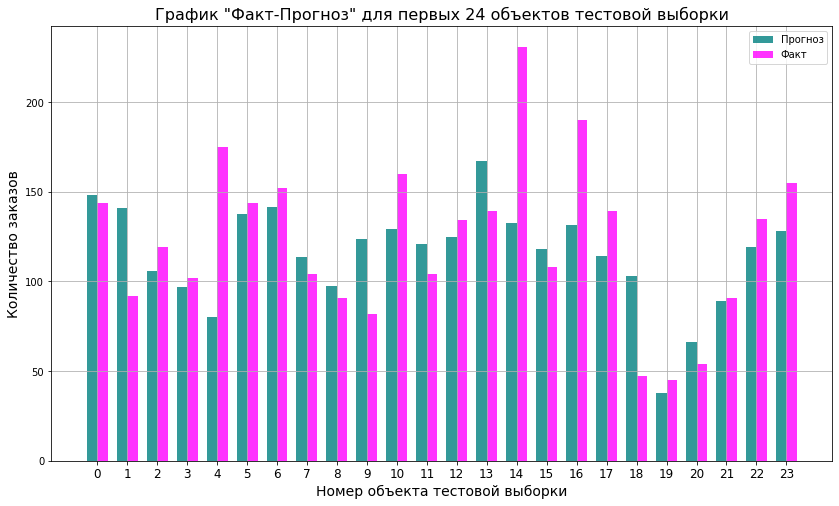

In [ ]:
plt.figure(figsize=(14, 8))

bar_width = 0.35
opacity = 0.8

plt.bar(np.arange(0, 24) - bar_width/2, net_test_preds[0:24].detach().numpy(), bar_width, alpha=opacity, color='teal', label='Прогноз')
plt.bar(np.arange(0, 24) + bar_width/2, y_test[0:24], bar_width, alpha=opacity, color='magenta', label='Факт')

plt.title('График для первых 24 объектов тестовой выборки', fontsize=16)
plt.xlabel('Номер объекта тестовой выборки', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.xticks(np.arange(0, 24), fontsize=12)
plt.grid()
plt.legend()
plt.show()

В результате тестирования было обнаружено, что лучшей моделью согласно метрике RMSE является Нейронная сеть. Значение RMSE составило 43.132, что удовлетворяет заданному условию, где требуется, чтобы RMSE было не более 48.